##Fine-Tuning CSRNet on CCTV Videos (Pseudo-Labels)

In [1]:
# ======================================================
# Task 3 Imports
# ======================================================
import os
import cv2
import time
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
# ======================================================
# Task 3 Configuration (Fast Fine-Tuning)
# ======================================================
TASK3_CONFIG = {
    "FRAME_STRIDE": 30,          # use 1 frame per second (30fps video)
    "MAX_FRAMES": 200,           # hard limit for speed
    "IMAGE_SIZE": (640, 360),    # downscale for faster CSRNet inference
    "BATCH_SIZE": 1,             # safest for CPU
    "EPOCHS": 2,                 # fine-tuning, not training
    "LEARNING_RATE": 1e-5,       # low LR
    "CHECKPOINT_NAME": "csrnet_task3_finetuned.pth"
}

In [3]:
# ======================================================
# Video Frame Extraction
# ======================================================
def extract_frames(video_path, stride, max_frames, resize):
    cap = cv2.VideoCapture(str(video_path))
    frames = []
    idx = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if idx % stride == 0:
            frame = cv2.resize(frame, resize)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)

            if len(frames) >= max_frames:
                break

        idx += 1

    cap.release()
    return frames

In [4]:
# ======================================================
# Pseudo-Label Dataset
# ======================================================
class PseudoCrowdDataset(Dataset):
    def __init__(self, video_dir, model, device, config):
        self.samples = []
        self.model = model
        self.device = device
        self.model.eval()

        video_dir = Path(video_dir)
        assert video_dir.exists(), "Video directory not found"

        for video_file in video_dir.glob("*.mp4"):
            frames = extract_frames(
                video_file,
                stride=config["FRAME_STRIDE"],
                max_frames=config["MAX_FRAMES"],
                resize=config["IMAGE_SIZE"]
            )

            for frame in frames:
                img = torch.from_numpy(frame).permute(2, 0, 1).float() / 255.0
                img = img.unsqueeze(0).to(device)

                with torch.no_grad():
                    density = self.model(img)

                self.samples.append((
                    img.squeeze(0).cpu(),
                    density.squeeze(0).cpu()
                ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


In [5]:
# ======================================================
# Visualization: Frame vs Density Map
# ======================================================
def visualize_sample(dataset, index=0):
    img, density = dataset[index]

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title("CCTV Frame")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(density.squeeze(), cmap="jet")
    plt.title(f"Pseudo Density Map\nCount ≈ {density.sum():.1f}")
    plt.axis("off")

    plt.show()


In [10]:
# ======================================================
# Device Configuration
# ======================================================

DEVICE = torch.device("cpu")
print("Using device:", DEVICE)

Using device: cpu


In [11]:
# ======================================================
# CSRNet Architecture (MATCHES Task 1 & Task 2 EXACTLY)
# ======================================================

from torchvision import models

class CSRNet(nn.Module):
    def __init__(self, load_pretrained_vgg=False):
        super().__init__()

        if load_pretrained_vgg:
            from torchvision.models import VGG16_Weights
            vgg = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        else:
            vgg = models.vgg16(weights=None)

        # Frontend: VGG16 conv layers up to conv4_3
        self.frontend = nn.Sequential(*list(vgg.features.children())[:23])

        # Backend: dilated convolutions (ENDS AT 64 CHANNELS)
        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
        )

        self.output_layer = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x


In [12]:
# ======================================================
# Load Pre-Trained CSRNet Weights
# ======================================================

PRETRAINED_PATH = "csrnet_weights.pth"   # from Task 1

assert os.path.exists(PRETRAINED_PATH), "Pre-trained CSRNet weights not found"

model = CSRNet().to(DEVICE)
state = torch.load(PRETRAINED_PATH, map_location=DEVICE)
model.load_state_dict(state)

print("Loaded pre-trained CSRNet weights.")

Loaded pre-trained CSRNet weights.


In [13]:
# ======================================================
# Freeze Frontend Layers
# ======================================================

for name, param in model.named_parameters():
    if "frontend" in name:
        param.requires_grad = False

print("Frozen CSRNet frontend layers.")


Frozen CSRNet frontend layers.


Total pseudo-labeled frames: 134


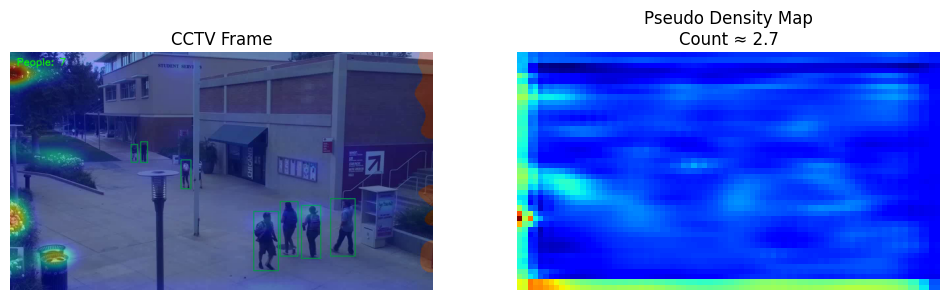

In [15]:
# ======================================================
# Dataset Creation
# ======================================================
VIDEO_DIR = Path(r"C:\Users\ARTI\OneDrive\Desktop\projects\cd\videoDataset")  # no hardcoding

dataset = PseudoCrowdDataset(
    video_dir=VIDEO_DIR,
    model=model,
    device=DEVICE,
    config=TASK3_CONFIG
)

print("Total pseudo-labeled frames:", len(dataset))

# Visual check
visualize_sample(dataset, index=0)


In [16]:
# ======================================================
# Fine-Tuning Setup
# ======================================================
loader = DataLoader(
    dataset,
    batch_size=TASK3_CONFIG["BATCH_SIZE"],
    shuffle=True
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=TASK3_CONFIG["LEARNING_RATE"]
)

In [17]:
# ======================================================
# Fine-Tuning Loop
# ======================================================
model.train()
start = time.time()

for epoch in range(1, TASK3_CONFIG["EPOCHS"] + 1):
    running_loss = 0.0

    for img, gt in loader:
        img = img.to(DEVICE)
        gt = gt.to(DEVICE)

        pred = model(img)

        if pred.shape != gt.shape:
            gt = nn.functional.interpolate(gt, size=pred.shape[2:])

        loss = criterion(pred, gt)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(loader)
    print(f"[Task 3] Epoch {epoch}/{TASK3_CONFIG['EPOCHS']} - Loss: {avg_loss:.6f}")

print("Fine-tuning completed in", round(time.time() - start, 2), "seconds")


[Task 3] Epoch 1/2 - Loss: 0.000000
[Task 3] Epoch 2/2 - Loss: 0.000000
Fine-tuning completed in 1912.0 seconds


In [18]:
# ======================================================
# Save Fine-Tuned Model
# ======================================================
torch.save(model.state_dict(), TASK3_CONFIG["CHECKPOINT_NAME"])
print("Fine-tuned model saved:", TASK3_CONFIG["CHECKPOINT_NAME"])

Fine-tuned model saved: csrnet_task3_finetuned.pth
